In [1]:
pip install tifffile

In [1]:
import os
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
from shapely.geometry import box
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from skimage.transform import resize
from joblib import Parallel, delayed
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib

# Define the paths
raster_directory = r"C:\Users\rishi\OneDrive\Desktop\sentinel_1"
shapefile_path = r"C:\Users\rishi\OneDrive\Desktop\merged for training\crop_data_merged.shp"
output_directory = r"C:\Users\rishi\OneDrive\Desktop\sentinel_1"

# Create the output directory if it does not exist
os.makedirs(output_directory, exist_ok=True)

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Print the CRS of the shapefile
print(f"Shapefile CRS: {gdf.crs}")

# Check if shapefile has the expected 'layer' column
assert 'layer' in gdf.columns, "Shapefile does not contain 'layer' column"

# Define the fixed shape for the features (e.g., 128x128)
fixed_shape = (128, 128)

def process_raster(filename):
    raster_path = os.path.join(raster_directory, filename)
    features = []
    targets = []

    with rasterio.open(raster_path) as src:
        print(f"Raster CRS: {src.crs}")
        if src.crs != gdf.crs:
            print(f"Reprojecting shapefile to match raster CRS")
            gdf_reprojected = gdf.to_crs(src.crs)
        else:
            gdf_reprojected = gdf

        raster_bounds = box(*src.bounds)
        print(f"Raster bounds: {raster_bounds.bounds}")

        intersecting_features = gdf_reprojected[gdf_reprojected.intersects(raster_bounds)]
        print(f"Number of intersecting features: {len(intersecting_features)}")

        if not intersecting_features.empty:
            for feature in intersecting_features.itertuples():
                geom = feature.geometry
                Layer = feature.layer
                out_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)
                resized_image = resize(out_image[0], fixed_shape, mode='reflect', anti_aliasing=True)
                features.append(resized_image.flatten())
                targets.append(Layer)
    
    return features, targets

# Use parallel processing to handle multiple files concurrently
results = Parallel(n_jobs=-1)(delayed(process_raster)(filename) for filename in os.listdir(raster_directory) if filename.endswith('.tif'))

# Combine results from all parallel processes
all_features = []
all_targets = []
for f, t in results:
    all_features.extend(f)
    all_targets.extend(t)

# Debugging: Print the number of features and targets collected
print(f"Number of features collected: {len(all_features)}")
print(f"Number of targets collected: {len(all_targets)}")

assert len(all_features) == len(all_targets), "Mismatch between number of images and target values"

X = np.array(all_features)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(np.array(all_targets))

if len(X) == 0 or len(y) == 0:
    raise ValueError("No samples collected. Ensure that the raster data and shapefile have corresponding overlaps.")

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X_scaled, y)

# Handling imbalanced data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_new, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2']  # Avoid using 'auto'
}

model = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

# Train the best model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Visualize the true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Save the model
model_path = r"C:\Users\rishi\OneDrive\Desktop\best_model.joblib"
joblib.dump(best_model, model_path)

print(f"Model saved to {model_path}")

Shapefile CRS: EPSG:4326
Number of features collected: 1408
Number of targets collected: 1408


NameError: name 'X_resampled' is not defined

Shapefile CRS: EPSG:4326
Number of features collected: 1408
Number of targets collected: 1408
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Mean Squared Error: 3.5
Accuracy: 0.3191489361702128


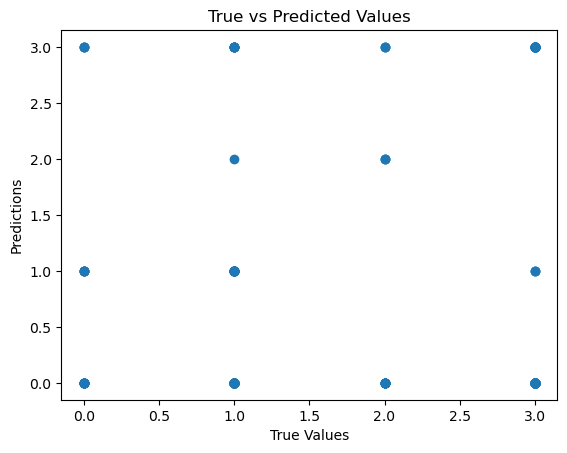

Label Mapping: {'Crop_class_Garlic': 0, 'Crop_class_Onion1': 1, 'Crop_class_Wheat1': 2, 'Crop_class_Wheat2': 3}
Model saved to C:\Users\rishi\OneDrive\Desktop\best_model.joblib


In [2]:
import os
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
from shapely.geometry import box
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from skimage.transform import resize
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import joblib

# Define the paths
raster_directory = r"C:\Users\rishi\OneDrive\Desktop\sentinel_1"
shapefile_path = r"C:\Users\rishi\OneDrive\Desktop\merged for training\crop_data_merged.shp"
output_directory = r"C:\Users\rishi\OneDrive\Desktop\sentinel_1"

# Create the output directory if it does not exist
os.makedirs(output_directory, exist_ok=True)

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Print the CRS of the shapefile
print(f"Shapefile CRS: {gdf.crs}")

# Check if shapefile has the expected 'layer' column
assert 'layer' in gdf.columns, "Shapefile does not contain 'layer' column"

# Define the fixed shape for the features (e.g., 128x128)
fixed_shape = (128, 128)

def process_raster(filename):
    raster_path = os.path.join(raster_directory, filename)
    features = []
    targets = []

    with rasterio.open(raster_path) as src:
        print(f"Raster CRS: {src.crs}")
        if src.crs != gdf.crs:
            print(f"Reprojecting shapefile to match raster CRS")
            gdf_reprojected = gdf.to_crs(src.crs)
        else:
            gdf_reprojected = gdf

        raster_bounds = box(*src.bounds)
        print(f"Raster bounds: {raster_bounds.bounds}")

        intersecting_features = gdf_reprojected[gdf_reprojected.intersects(raster_bounds)]
        print(f"Number of intersecting features: {len(intersecting_features)}")

        if not intersecting_features.empty:
            for feature in intersecting_features.itertuples():
                geom = feature.geometry
                Layer = feature.layer
                out_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)
                resized_image = resize(out_image[0], fixed_shape, mode='reflect', anti_aliasing=True)
                features.append(resized_image.flatten())
                targets.append(Layer)
    
    return features, targets

# Use parallel processing to handle multiple files concurrently
results = Parallel(n_jobs=-1)(delayed(process_raster)(filename) for filename in os.listdir(raster_directory) if filename.endswith('.tif'))

# Combine results from all parallel processes
all_features = []
all_targets = []
for f, t in results:
    all_features.extend(f)
    all_targets.extend(t)

# Debugging: Print the number of features and targets collected
print(f"Number of features collected: {len(all_features)}")
print(f"Number of targets collected: {len(all_targets)}")

assert len(all_features) == len(all_targets), "Mismatch between number of images and target values"

X = np.array(all_features)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(np.array(all_targets))

if len(X) == 0 or len(y) == 0:
    raise ValueError("No samples collected. Ensure that the raster data and shapefile have corresponding overlaps.")

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X_scaled, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Model tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2']  # Avoid using 'auto'
}

model = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

# Train the best model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Visualize the true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Save the model
model_path = r"C:\Users\rishi\OneDrive\Desktop\best_model.joblib"
joblib.dump(best_model, model_path)

print(f"Model saved to {model_path}")
